Based on this tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

In [26]:
# load dataset with sentiment columns
tweet_data = pd.read_csv('data_lg_clean_sentiment.csv').dropna()

### Preprocess data

In [27]:
tweet_data = tweet_data[tweet_data['created_at']!='0']
tweet_data['created_at'] = pd.to_datetime(tweet_data['created_at'], format="%Y-%m-%d %H:%M:%S")


In [30]:
tweet_data['dates'] = tweet_data['created_at'].apply(lambda x: x.date())

In [32]:
tweet_data = tweet_data.set_index('created_at')
tweet_data.index.date

array([datetime.date(2022, 7, 26), datetime.date(2022, 7, 26),
       datetime.date(2022, 7, 26), ..., datetime.date(2022, 8, 1),
       datetime.date(2022, 8, 1), datetime.date(2022, 8, 1)], dtype=object)

In [35]:
reduced_tweet_data = tweet_data[tweet_data.index.date == tweet_data['dates'].unique()[2]]

In [49]:
reduced_tweet_data.head()

,tweet_id,tweet,like_count,quote_count,reply_count,retweet_count,clean,hashtags,clean_spacy,tmp,neg,pos,neu,compound,sentiment,dates
created_at,,,,,,,,,,,,,,,,
2022-07-28 00:59:53,1552458788246114304,"President Biden got another win, Chunk &amp; M...",1.0,0.0,0.0,1.0,president biden got another win chunk manchin ...,[],president biden win chunk manchin agree high t...,"{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compou...",0.000,0.380,0.620,0.9287,pos,2022-07-28
2022-07-28 00:59:32,1552458703810560001,@Kobrakie32 @pi_slaught @JDVance1 And that's g...,1.0,0.0,1.0,0.0,and thats going to bring industry back because...,[],s bring industry progressive tendency cozy cor...,"{'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'comp...",0.000,0.081,0.919,0.5330,pos,2022-07-28
2022-07-28 00:59:31,1552458697078878208,@AZ_Brittney He’s handling one crisis after an...,3.0,0.0,0.0,0.0,hes handling one crisis after another gas pric...,[],s handle crisis gas price war inflation covid ...,"{'neg': 0.185, 'neu': 0.695, 'pos': 0.12, 'com...",0.185,0.120,0.695,-0.5719,neg,2022-07-28
2022-07-28 00:59:29,1552458689021259776,@colin_korol You have to watch that climate ch...,4.0,0.0,0.0,0.0,you have to watch that climate change it sneak...,[],watch climate change sneak ya,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.0000,neu,2022-07-28
2022-07-28 00:59:26,1552458675054313473,Keep telling the climate change hoaxers. Wildf...,1.0,0.0,0.0,1.0,keep telling the climate change hoaxers wildfi...,[],tell climate change hoaxer wildfire stop guy s...,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",0.239,0.000,0.761,-0.5267,neg,2022-07-28


/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: Deprecatio

In [37]:
words = reduced_tweet_data['clean_spacy'].apply(lambda x: word_tokenize(x))

In [39]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[words[0]]])

['president', 'biden', 'win', 'chunk', 'manchin', 'agree', 'high', 'taxis', 'rich', 'clean', 'energy', 'climate', 'change', 'president', 'biden', 'democrats', 'vote', 'blue']


In [40]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

### LDA

In [41]:
data_words_bigrams = make_trigrams(words)
data_words_bigrams[2]

['s',
 'handle',
 'crisis',
 'gas_price',
 'war',
 'inflation',
 'covid',
 'want',
 'support',
 'strengthen',
 'tackle',
 'voting_right',
 'climate',
 'change',
 'women',
 'right',
 'sex_marriage',
 'equality']

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
# id2word = corpora.Dictionary(bigram)
id2word.filter_extremes(no_below=10, no_above=0.35)
id2word.compactify()
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [73]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: Deprecatio

In [74]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.029*"bill" + 0.019*"inflation" + 0.018*"support" + 0.016*"new" + '
  '0.013*"health_care" + 0.012*"big" + 0.011*"energy" + 0.011*"biden" + '
  '0.011*"address" + 0.010*"vote"'),
 (1,
  '0.045*"s" + 0.026*"fight" + 0.023*"sen_joe_manchin" + 0.023*"podcast" + '
  '0.022*"act" + 0.021*"package_story_daily_news" + 0.021*"joe_biden_praise" + '
  '0.021*"economy_shrank_president" + 0.016*"inflation_reduction" + '
  '0.015*"reduce"'),
 (2,
  '0.019*"people" + 0.014*"like" + 0.012*"time" + 0.011*"need" + 0.010*"think" '
  '+ 0.010*"year" + 0.010*"know" + 0.010*"right" + 0.008*"cause" + '
  '0.007*"real"')]

Coherence Score:  0.4313059380302442


In [75]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.285155 -0.225516       1        1  50.959482
0     -0.346271 -0.124020       2        1  32.399082
1      0.061116  0.349536       3        1  16.641437, topic_info=                          Term         Freq        Total Category  logprob  \
23                           s  1743.000000  1743.000000  Default  30.0000   
304                       bill  2156.000000  2156.000000  Default  29.0000   
236                      fight   997.000000   997.000000  Default  28.0000   
577            sen_joe_manchin   901.000000   901.000000  Default  27.0000   
3243                   podcast   898.000000   898.000000  Default  26.0000   
...                        ...          ...          ...      ...      ...   
3679  economy_shrank_president   786.219246   854.162479   Topic3  -3.8870   
3680          joe_biden_praise   786.219246   854.162479   Topic3  -3.8870   
3681  package_story_daily_news   786.219246   854.162479   Topic3  -3.8870   
134                       help   392.025474   961.413851   Topic3  -4.5829   
392                      world   301.944402  1047.624648   Topic3  -4.8440   

      loglift  
23    30.0000  
304   29.0000  
236   28.0000  
577   27.0000  
3243  26.0000  
...       ...  
3679   1.7104  
3680   1.7104  
3681   1.7104  
134    0.8962  
392    0.5492  

[134 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
72        1  0.002198      10
72        3  0.998012      10
303       1  0.998605     I_m
339       3  0.999447     act
174       1  0.998854  action
...     ...       ...     ...
353       1  0.999087    work
392       1  0.711133   world
392       3  0.288271   world
220       1  0.988679    year
220       3  0.010578    year

[119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [76]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=1, limit=12, step=1)

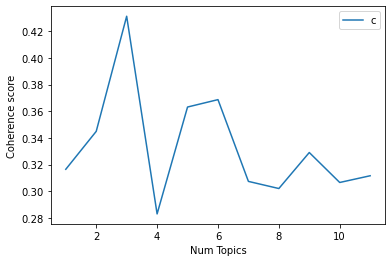

In [77]:
# Show graph
import matplotlib.pyplot as plt
limit=12; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [78]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3165
Num Topics = 2  has Coherence Value of 0.3449
Num Topics = 3  has Coherence Value of 0.4313
Num Topics = 4  has Coherence Value of 0.283
Num Topics = 5  has Coherence Value of 0.3632
Num Topics = 6  has Coherence Value of 0.3687
Num Topics = 7  has Coherence Value of 0.3074
Num Topics = 8  has Coherence Value of 0.302
Num Topics = 9  has Coherence Value of 0.329
Num Topics = 10  has Coherence Value of 0.3066
Num Topics = 11  has Coherence Value of 0.3116


/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: Deprecatio